Net injections: [  5  10 -12  -8   5]
Flows: {('Slack', 'A'): -1.4636512840316658, ('Slack', 'B'): 6.463651284031668, ('A', 'B'): 3.963651284031667, ('A', 'C'): 4.5726974319366676, ('B', 'D'): -1.5726974319366676, ('C', 'D'): -3.427302568063333}


Симуляция resiliency: 100%|██████████| 10/10 [00:00<?, ?it/s]


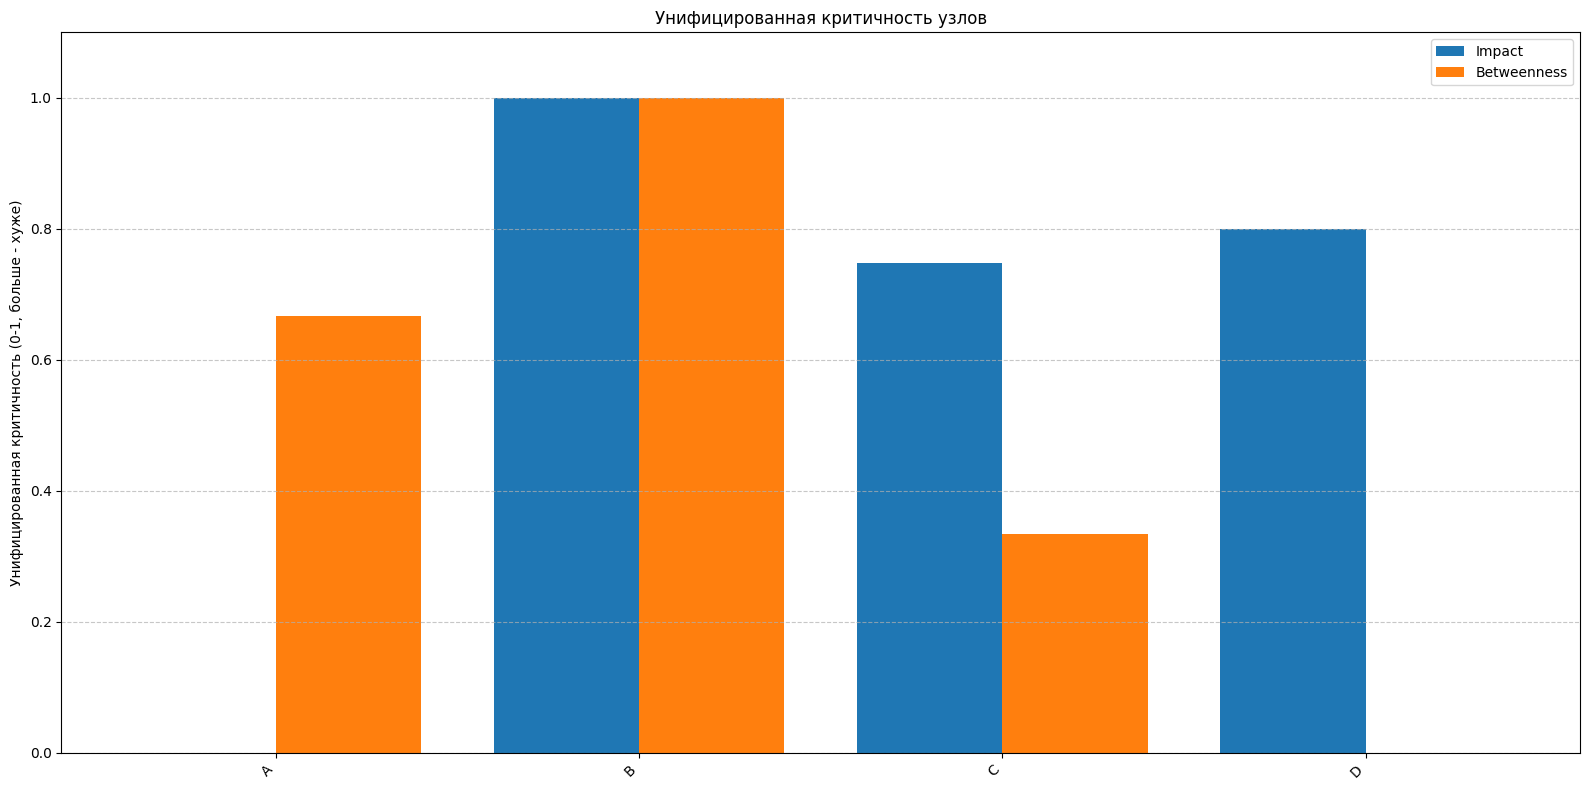

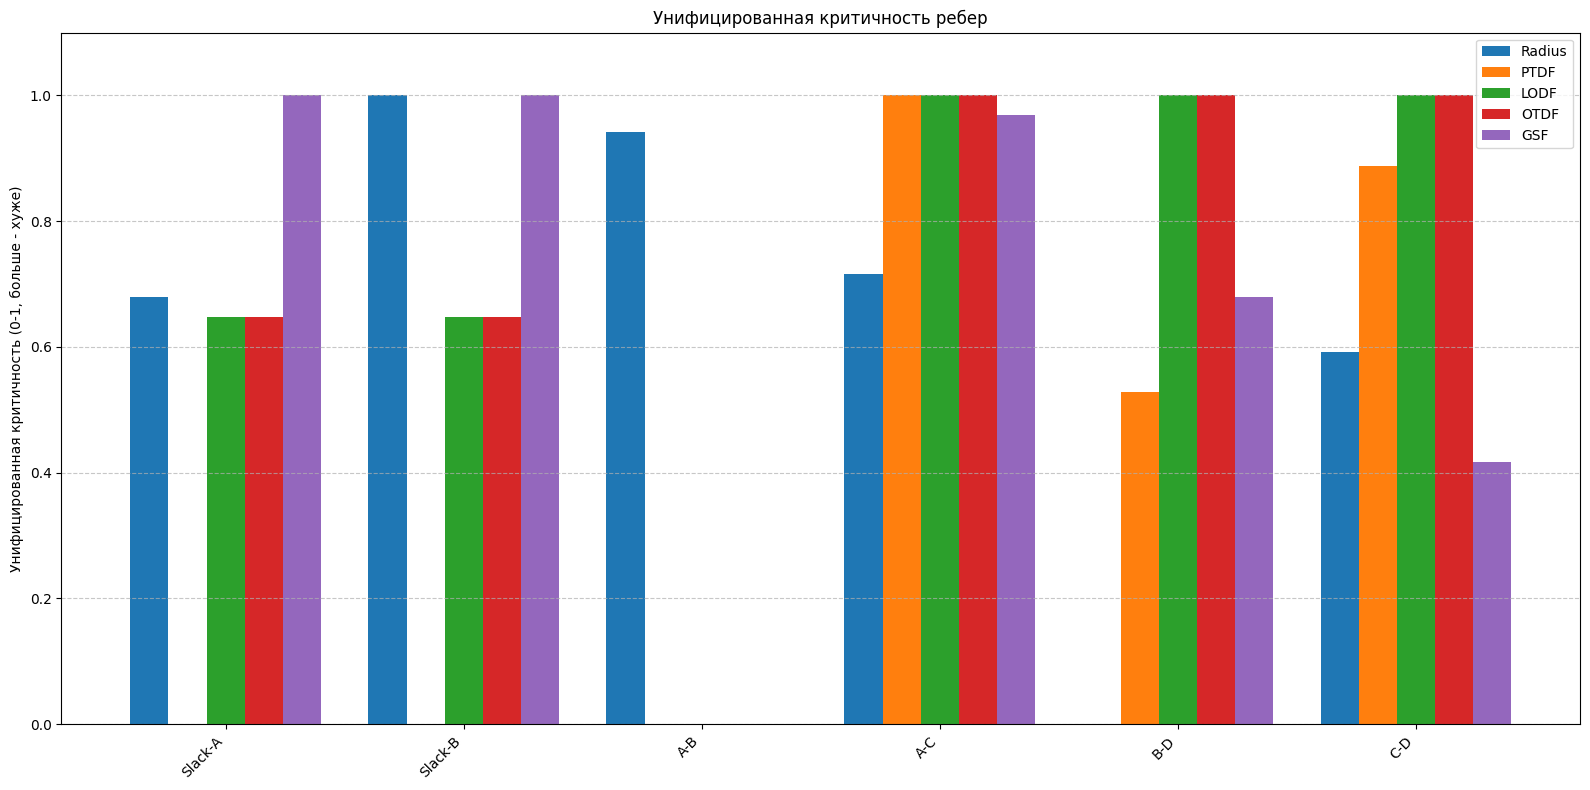

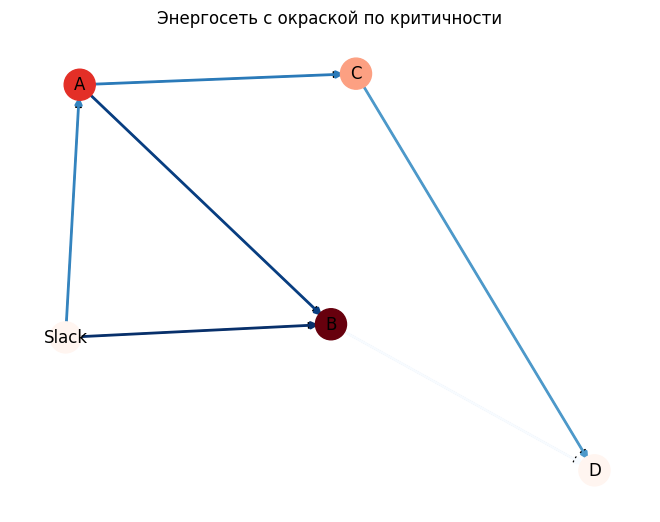

VSI: 62.74149032542805 (больше - хуже)
EENS: 15.873078570585609 (больше - хуже)
Clustering: 0.3333333333333333 (меньше - хуже, норм: 1 - 0.6666666666666667)
Alg Connectivity: 1.3819660112501049 (меньше - хуже, норм: 1 - 0.5)


In [1]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from networkx.algorithms.flow import maximum_flow
from tqdm import tqdm

# Новая функция создания графа с power injections
def create_distributed_energy_network():
    G = nx.DiGraph()
    
    # Теперь у каждого узла есть генерация и нагрузка
    nodes_data = {
        'Slack': {'generation': 0, 'load': 0}, 
        'A': {'generation': 15, 'load': 5},   # +10
        'B': {'generation': 0,  'load': 12},  # -12
        'C': {'generation': 0,  'load': 8},   # -8
        'D': {'generation': 10, 'load': 5},   # +5
    }
    
    # Рассчитываем чистый ввод для балансирующего узла
    net_injection_sum = sum(d['generation'] - d['load'] for node, d in nodes_data.items() if node != 'Slack')
    nodes_data['Slack']['generation'] = -net_injection_sum  # +5 to balance to 0

    for node, data in nodes_data.items():
        G.add_node(node, **data)

    # Ребра
    edges = [
        ('A', 'B', {'capacity': 10, 'reactance': 0.1}),
        ('A', 'C', {'capacity': 8, 'reactance': 0.125}),
        ('B', 'D', {'capacity': 5, 'reactance': 0.2}),
        ('C', 'D', {'capacity': 7, 'reactance': 0.1429}),
        ('Slack', 'A', {'capacity': 20, 'reactance': 0.05}),
        ('Slack', 'B', {'capacity': 20, 'reactance': 0.05}),
    ]
    G.add_edges_from([(u, v, d) for u, v, d in edges])
    
    return G

# Функция для расчета net injections
def get_net_injections(G, nodes):
    P = np.array([G.nodes[n]['generation'] - G.nodes[n]['load'] for n in nodes])
    return P

# Расчет потоков с DC Power Flow
def compute_power_flows(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes)
    n = len(nodes)
    P = get_net_injections(G, nodes)
    
    # Удаляем slack bus
    B_prime = np.delete(np.delete(B, slack_idx, axis=0), slack_idx, axis=1)
    P_prime = np.delete(P, slack_idx)
    theta_prime = la.solve(B_prime, P_prime)
    
    # Полная theta
    theta = np.zeros(n)
    theta[slack_idx + 1:] = theta_prime
    
    # Потоки
    flows = {}
    for u, v in G.edges():
        idx_u = nodes.index(u)
        idx_v = nodes.index(v)
        b_uv = 1 / G[u][v]['reactance']
        flow = b_uv * (theta[idx_u] - theta[idx_v])
        flows[(u, v)] = flow
    
    return flows, theta, P

# Адаптированный радиус устойчивости для ребер (на изменения reactance)
def compute_edge_stability_radius(G, nodes, original_flows, slack_idx=0):
    radii = {}
    for u, v in tqdm(G.edges(), desc="Расчет радиусов устойчивости"):
        original_x = G[u][v]['reactance']
        low, high = 0, original_x * 2
        for _ in range(20):
            mid = (low + high) / 2
            G[u][v]['reactance'] = original_x + mid
            new_flows, _, _ = compute_power_flows(G, nodes, slack_idx)
            change = max([abs(new_flows.get(e, 0) - original_flows.get(e, 0)) for e in G.edges()])
            if change > 1e-3:
                high = mid
            else:
                low = mid + 1e-6
        radii[(u, v)] = low
        G[u][v]['reactance'] = original_x
    return radii

# Адаптированные критические узлы: perturbation injection
def identify_critical_nodes(G, nodes, original_flows, slack_idx=0):
    betweenness = nx.betweenness_centrality(G)
    impact = {}
    for node in tqdm(nodes, desc="Анализ узлов"):
        if node == nodes[slack_idx]: continue
        original_P = get_net_injections(G, nodes).copy()
        idx = nodes.index(node)
        perturb = original_P[idx] * 0.1
        new_P = original_P.copy()
        new_P[idx] -= perturb
        new_P[slack_idx] += perturb  # Баланс на slack
        
        B = build_susceptance_matrix(G, nodes)
        B_prime = np.delete(np.delete(B, slack_idx, axis=0), slack_idx, axis=1)
        theta_prime = la.solve(B_prime, new_P[slack_idx+1:])
        theta = np.zeros(len(nodes))
        theta[slack_idx+1:] = theta_prime
        
        new_flows = {}
        for u, v in G.edges():
            idx_u = nodes.index(u)
            idx_v = nodes.index(v)
            b_uv = 1 / G[u][v]['reactance']
            new_flows[(u, v)] = b_uv * (theta[idx_u] - theta[idx_v])
        
        total_change = sum(abs(new_flows.get(e, 0) - original_flows.get(e, 0)) for e in G.edges())
        impact[node] = total_change
    return betweenness, impact

# Функции для всех метрик
def build_susceptance_matrix(G, nodes):
    n = len(nodes)
    B = np.zeros((n, n))
    node_idx = {node: i for i, node in enumerate(nodes)}
    for u, v in G.edges():
        reactance = G[u][v]['reactance']
        susceptance = 1 / reactance
        idx_u = node_idx[u]
        idx_v = node_idx[v]
        B[idx_u, idx_u] += susceptance
        B[idx_v, idx_v] += susceptance
        B[idx_u, idx_v] -= susceptance
        B[idx_v, idx_u] -= susceptance
    return B

def compute_ptdf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes)
    n = len(nodes)
    B_prime = np.delete(np.delete(B, slack_idx, axis=0), slack_idx, axis=1)
    B_inv = la.inv(B_prime)
    X = np.zeros((n, n))
    X[np.ix_(list(range(slack_idx)) + list(range(slack_idx+1, n)), list(range(slack_idx)) + list(range(slack_idx+1, n)))] = B_inv
    ptdf = {}
    edges = list(G.edges())
    for i in range(n):
        for j in range(n):
            if i == j or i == slack_idx or j == slack_idx: continue
            key = (nodes[i], nodes[j])
            ptdf[key] = {}
            for u, v in edges:
                idx_u = nodes.index(u)
                idx_v = nodes.index(v)
                b_l = 1 / G[u][v]['reactance']
                ptdf_val = b_l * (X[idx_u, i] - X[idx_u, j] - X[idx_v, i] + X[idx_v, j])
                ptdf[key][(u, v)] = ptdf_val
    return ptdf

def compute_lodf(G, nodes, ptdf, slack_idx=0):
    lodf = {}
    edges = list(G.edges())
    for k_edge in edges:
        k_from, k_to = k_edge
        trans_from = k_from
        trans_to = k_to
        if (trans_from, trans_to) not in ptdf: continue
        ptdf_k = ptdf[(trans_from, trans_to)][k_edge]
        if abs(1 - ptdf_k) < 1e-6: continue
        for m_edge in edges:
            if m_edge == k_edge: continue
            ptdf_m = ptdf[(trans_from, trans_to)][m_edge]
            lodf[(m_edge, k_edge)] = ptdf_m / (1 - ptdf_k)
    return lodf

def compute_otdf(G, nodes, ptdf, lodf, slack_idx=0):
    otdf = {}
    edges = list(G.edges())
    trans_pairs = list(ptdf.keys())
    for trans in trans_pairs:
        for m_edge in edges:
            for k_edge in edges:
                if k_edge == m_edge: continue
                if (k_edge, m_edge) in lodf:
                    lodf_val = lodf[(k_edge, m_edge)]
                    ptdf_val = ptdf[trans].get(k_edge, 0)
                    otdf[(k_edge, trans, m_edge)] = ptdf_val + lodf_val * ptdf[trans].get(m_edge, 0)
                else:
                    otdf[(k_edge, trans, m_edge)] = 0
    return otdf

def compute_gsf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes)
    n = len(nodes)
    B_prime = np.delete(np.delete(B, slack_idx, axis=0), slack_idx, axis=1)
    B_inv = la.inv(B_prime)
    X = np.zeros((n, n))
    X[np.ix_(list(range(slack_idx)) + list(range(slack_idx+1, n)), list(range(slack_idx)) + list(range(slack_idx+1, n)))] = B_inv
    gsf = {}
    edges = list(G.edges())
    for i in range(n):
        if i == slack_idx: continue
        gsf[nodes[i]] = {}
        for u, v in edges:
            idx_u = nodes.index(u)
            idx_v = nodes.index(v)
            b_l = 1 / G[u][v]['reactance']
            gsf_val = b_l * (X[idx_u, i] - X[idx_v, i])
            gsf[nodes[i]][(u, v)] = gsf_val
    return gsf

def compute_vsi(G, nodes):
    B = build_susceptance_matrix(G, nodes)
    eigenvalues = np.linalg.eigvals(B)
    vsi = np.max(np.abs(eigenvalues))
    return vsi

def compute_graph_metrics(G):
    clustering = nx.average_clustering(G.to_undirected())
    L = nx.laplacian_matrix(G.to_undirected()).todense()
    eigenvalues = np.linalg.eigvals(L)
    alg_conn = sorted(np.real(eigenvalues))[1]
    return {'clustering': clustering, 'alg_connectivity': alg_conn}

def compute_resiliency_indices(G, nodes, slack_idx=0, num_sim=10):
    original_flows, _, _ = compute_power_flows(G, nodes, slack_idx)
    losses = []
    edges = list(G.edges())
    for _ in tqdm(range(num_sim), desc="Симуляция resiliency"):
        G_copy = G.copy()
        remove_edge = edges[np.random.choice(len(edges))]
        G_copy.remove_edge(*remove_edge)
        try:
            new_flows, _, _ = compute_power_flows(G_copy, nodes, slack_idx)
            loss = np.sum(np.abs([new_flows.get(e, 0) - original_flows.get(e, 0) for e in edges]))
        except Exception as e:
            loss = np.inf
        losses.append(loss)
    eens = np.mean([l for l in losses if np.isfinite(l)])
    return {'EENS': eens}

# Нормализация (чем больше нормализованное значение, тем хуже критичность)
def normalize_metric(values, invert=False):
    if not values: return []
    min_v, max_v = min(values), max(values)
    if min_v == max_v: return [0.5] * len(values)
    norm = [(v - min_v) / (max_v - min_v) for v in values]
    return norm if not invert else [1 - n for n in norm]

# Визуализация унифицированной критичности
def visualize_unified_criticality(title, labels, **metrics):
    x = np.arange(len(labels))
    num_metrics = len(metrics)
    width = 0.8 / num_metrics
    fig, ax = plt.subplots(figsize=(16, 8))
    for i, (name, values) in enumerate(metrics.items()):
        offset = width * (i - num_metrics / 2 + 0.5)
        ax.bar(x + offset, values, width, label=name)
    ax.set_ylabel('Унифицированная критичность (0-1, больше - хуже)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.show()

# Визуализация графа с окраской
def visualize_colored_graph(G, betweenness, edge_radii):
    pos = nx.spring_layout(G)
    node_values = [betweenness.get(n, 0) for n in G.nodes()]
    norm_nodes = normalize_metric(node_values)
    edge_values = [edge_radii.get(e, 0) for e in G.edges()]
    norm_edges = normalize_metric(edge_values, invert=True)  # Инверт для критичности
    nx.draw(G, pos, with_labels=True, node_color=norm_nodes, cmap=plt.cm.Reds, node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color=norm_edges, edge_cmap=plt.cm.Blues, width=2)
    plt.title("Энергосеть с окраской по критичности")
    plt.show()

# Основная функция
def main():
    G = create_distributed_energy_network()
    nodes = list(G.nodes())
    edges = list(G.edges())
    slack_idx = 0  # 'Slack'
    
    flows, theta, P = compute_power_flows(G, nodes, slack_idx)
    print("Net injections:", P)
    print("Flows:", flows)
    
    edge_radii = compute_edge_stability_radius(G, nodes, flows, slack_idx)
    betweenness, impact = identify_critical_nodes(G, nodes, flows, slack_idx)
    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, nodes, ptdf, slack_idx)
    otdf = compute_otdf(G, nodes, ptdf, lodf, slack_idx)
    gsf = compute_gsf(G, nodes, slack_idx)
    vsi = compute_vsi(G, nodes)
    graph_metrics = compute_graph_metrics(G)
    resiliency = compute_resiliency_indices(G, nodes, slack_idx)
    
    # Нормализация
    internal_nodes = [n for n in nodes if n != 'Slack']
    impact_values = [impact.get(n, 0) for n in internal_nodes]
    norm_impact = normalize_metric(impact_values)
    between_values = [betweenness.get(n, 0) for n in internal_nodes]
    norm_between = normalize_metric(between_values)
    
    crit_radius = normalize_metric([edge_radii.get(e, 0) for e in edges], invert=True)
    crit_ptdf = normalize_metric([max(abs(ptdf[t].get(e, 0)) for t in ptdf) if ptdf else 0 for e in edges])
    crit_lodf = normalize_metric([max(abs(lodf.get((e, k), 0)) for k in edges if k != e) if lodf else 0 for e in edges])
    crit_otdf = normalize_metric([max(abs(otdf.get((e, t, m), 0)) for t in ptdf for m in edges if m != e) if otdf else 0 for e in edges])
    crit_gsf = normalize_metric([max(abs(gsf[n].get(e, 0)) for n in gsf) if gsf else 0 for e in edges])
    
    # Визуализация
    visualize_unified_criticality('Унифицированная критичность узлов', internal_nodes, Impact=norm_impact, Betweenness=norm_between)
    visualize_unified_criticality('Унифицированная критичность ребер', [f"{u}-{v}" for u, v in edges],
                                  Radius=crit_radius, PTDF=crit_ptdf, LODF=crit_lodf, OTDF=crit_otdf, GSF=crit_gsf)
    visualize_colored_graph(G, betweenness, edge_radii)
    
    # Вывод системных метрик
    print(f"VSI: {vsi} (больше - хуже)")
    print(f"EENS: {resiliency['EENS']} (больше - хуже)")
    print(f"Clustering: {graph_metrics['clustering']} (меньше - хуже, норм: 1 - {1 - graph_metrics['clustering']})")
    print(f"Alg Connectivity: {graph_metrics['alg_connectivity']} (меньше - хуже, норм: 1 - {normalize_metric([graph_metrics['alg_connectivity']], invert=True)[0]})")

if __name__ == "__main__":
    main()

Этап 1: Расчет физических коэффициентов...


Расчет LODF: 100%|██████████| 6/6 [00:00<?, ?it/s]


Этап 2: Расчет базового состояния сети...
Этап 3: Расчет Уязвимости и Влиятельности...


Оценка Уязвимости и Влиятельности: 100%|██████████| 6/6 [00:00<00:00, 5797.24it/s]

Этап 4: Расчет Системного Индекса Критичности (SCI)...

--- Итоговая таблица с Уязвимостью и Влиятельностью ---
            line  vulnerability_score  influence_score    sci
0      Bus2-Bus4                0.882            1.000  0.941
1      Bus1-Bus2                1.000            0.818  0.909
2      Bus1-Bus3                0.882            0.364  0.623
3      Bus3-Bus4                0.647            0.000  0.324
4  Bus4-SlackBus                0.224            0.273  0.248
5  Bus1-SlackBus                0.000            0.091  0.045

ФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): 0.9131
✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности.


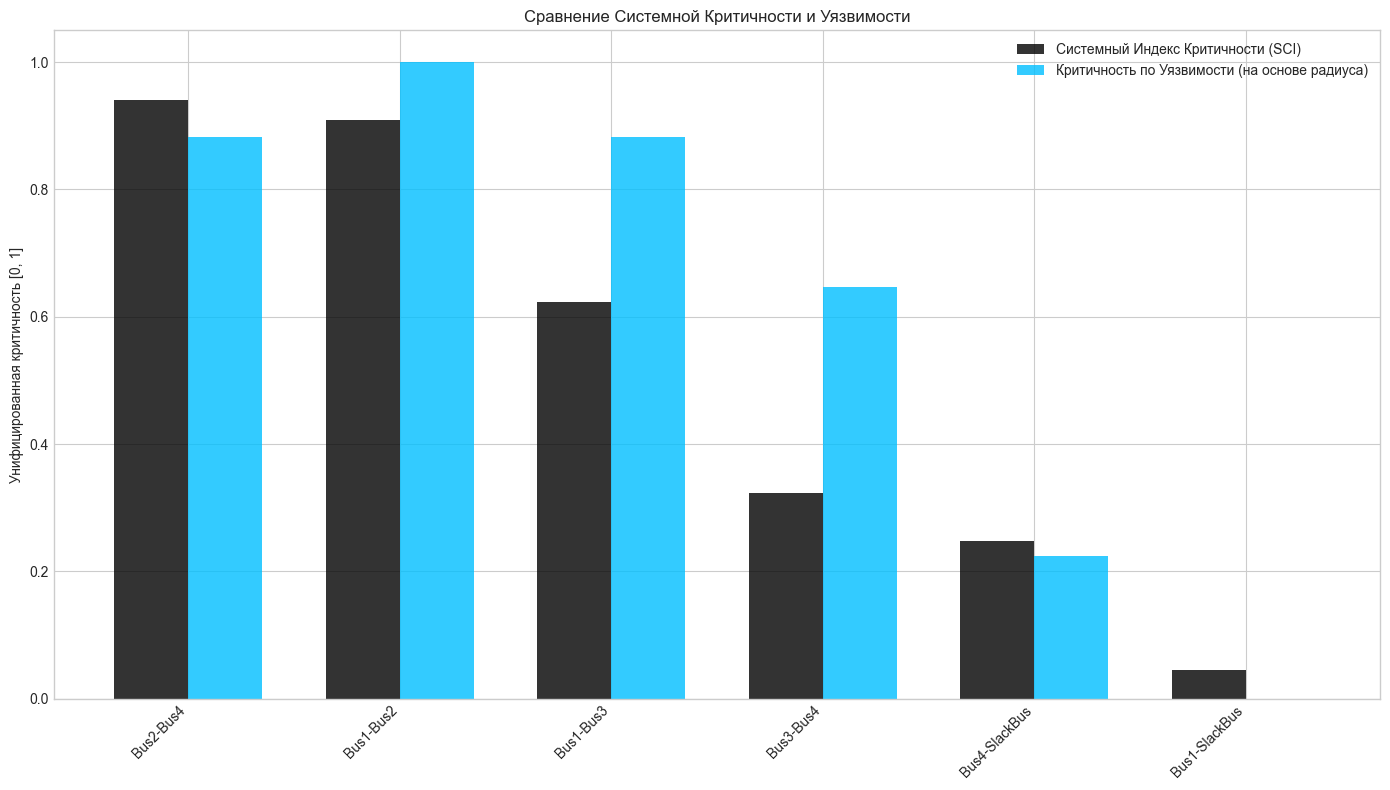

In [6]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# --- Функции расчета (скрыты для краткости, идентичны предыдущей версии) ---
def create_distributed_energy_network():
    G = nx.Graph()
    nodes_data = {
        'Bus1': {'generation': 150, 'load': 50}, 'Bus2': {'generation': 0, 'load': 120},
        'Bus3': {'generation': 0, 'load': 80}, 'Bus4': {'generation': 100, 'load': 50},
        'SlackBus': {'generation': 0, 'load': 0},
    }
    net_injection_sum = sum(d['generation'] - d['load'] for _, d in nodes_data.items())
    nodes_data['SlackBus']['generation'] = -net_injection_sum
    for node, data in nodes_data.items(): G.add_node(node, **data)
    edges_data = [
        ('Bus1', 'Bus2', {'capacity': 100, 'reactance': 0.1}), ('Bus1', 'Bus3', {'capacity': 80, 'reactance': 0.125}),
        ('Bus2', 'Bus4', {'capacity': 120, 'reactance': 0.08}), ('Bus3', 'Bus4', {'capacity': 120, 'reactance': 0.08}),
        ('SlackBus', 'Bus1', {'capacity': 200, 'reactance': 0.05}), ('SlackBus', 'Bus4', {'capacity': 200, 'reactance': 0.05}),
    ]
    G.add_edges_from([(u, v, d) for u, v, d in edges_data])
    return G

def build_susceptance_matrix(G, nodes):
    n = len(nodes); B = np.zeros((n, n)); node_idx = {node: i for i, node in enumerate(nodes)}
    for u, v, data in G.edges(data=True):
        susceptance = 1 / data.get('reactance', 1.0)
        idx_u, idx_v = node_idx[u], node_idx[v]
        B[idx_u, idx_u] += susceptance; B[idx_v, idx_v] += susceptance
        B[idx_u, idx_v] -= susceptance; B[idx_v, idx_u] -= susceptance
    return B

def compute_ptdf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes); n = len(nodes)
    non_slack = list(range(slack_idx)) + list(range(slack_idx + 1, n))
    B_prime = B[np.ix_(non_slack, non_slack)]; B_inv = la.inv(B_prime)
    X = np.zeros((n, n)); X[np.ix_(non_slack, non_slack)] = B_inv
    ptdf = {}; edges = list(G.edges(data=True)); node_idx = {node: i for i, node in enumerate(nodes)}
    for i in range(n):
        for j in range(n):
            if i == j: continue
            key = (nodes[i], nodes[j]); ptdf[key] = {}
            for u, v, data in edges:
                b_l = 1 / data['reactance']
                idx_u, idx_v = node_idx[u], node_idx[v]
                ptdf[key][(u,v)] = b_l * (X[idx_u, i] - X[idx_u, j] - X[idx_v, i] + X[idx_v, j])
    return ptdf

def compute_lodf(G, nodes, ptdf):
    lodf = {}; edges_map = {(u,v): (u,v) for u,v,d in G.edges(data=True)}; edges = list(edges_map.keys())
    for k_edge in tqdm(edges, desc="Расчет LODF"):
        k_from, k_to = k_edge
        trans_key = (k_from, k_to) if (k_from,k_to) in ptdf else (k_to,k_from)
        if trans_key not in ptdf: continue
        ptdf_k_on_k = ptdf[trans_key].get(k_edge, ptdf[trans_key].get((k_to,k_from),0))
        if abs(1 - ptdf_k_on_k) < 1e-6: continue
        for m_edge in edges:
            if m_edge == k_edge: continue
            m_from, m_to = m_edge
            ptdf_m_on_k = ptdf[trans_key].get(m_edge, ptdf[trans_key].get((m_to,m_from),0))
            lodf[(m_edge, k_edge)] = ptdf_m_on_k / (1 - ptdf_k_on_k)
    return lodf

def normalize_metric(data, invert=False):
    if not data or max(data) == min(data): return [0.5] * len(data)
    max_val, min_val = max(data), min(data)
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    return [1 - x for x in normalized] if invert else normalized

### ОСНОВНАЯ ЛОГИКА АНАЛИЗА ###
def main():
    G = create_distributed_energy_network()
    nodes = sorted(list(G.nodes()))
    edges = list(G.edges(data=True))
    edge_tuples = [(u, v) for u, v, d in edges]

    slack_node = 'SlackBus'
    slack_idx = nodes.index(slack_node)

    print("Этап 1: Расчет физических коэффициентов...")
    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, nodes, ptdf)

    print("Этап 2: Расчет базового состояния сети...")
    B_prime = np.delete(np.delete(build_susceptance_matrix(G, nodes), slack_idx, axis=0), slack_idx, axis=1)
    P_injections = np.array([G.nodes[n]['generation'] - G.nodes[n]['load'] for n in nodes if n != slack_node])
    theta_prime = la.solve(B_prime, P_injections)
    theta = np.insert(theta_prime, slack_idx, 0)
    node_idx = {node: i for i, node in enumerate(nodes)}

    base_case_flows = { (u, v): (1 / d['reactance']) * (theta[node_idx[u]] - theta[node_idx[v]]) for u, v, d in edges }
    
    print("Этап 3: Расчет Уязвимости и Влиятельности...")
    
    metrics_data = []
    for u_l, v_l, data_l in tqdm(edges, desc="Оценка Уязвимости и Влиятельности"):
        line_l = (u_l, v_l)
        
        # --- Расчет УЯЗВИМОСТИ (насколько линия страдает от других) ---
        worst_case_flow_on_l = abs(base_case_flows[line_l])
        for u_k, v_k, _ in edges:
            if (u_l, v_l) == (u_k, v_k): continue
            line_k = (u_k, v_k)
            lodf_val = lodf.get((line_l, line_k), 0)
            post_contingency_flow = base_case_flows[line_l] + lodf_val * base_case_flows[line_k]
            worst_case_flow_on_l = max(worst_case_flow_on_l, abs(post_contingency_flow))
        
        dynamic_stability_radius = data_l['capacity'] - worst_case_flow_on_l
        
        # --- Расчет ВЛИЯТЕЛЬНОСТИ (какой вред наносит отказ самой линии) ---
        # Ищем максимальный LODF, где наша линия l является причиной отказа
        max_impact_lodf = max([abs(lodf.get((k, line_l), 0)) for k in edge_tuples if k != line_l], default=0)

        metrics_data.append({
            'line': f"{u_l}-{v_l}",
            'vulnerability_radius': dynamic_stability_radius,
            'influence_lodf': max_impact_lodf,
        })

    df = pd.DataFrame(metrics_data)

    print("Этап 4: Расчет Системного Индекса Критичности (SCI)...")
    # Нормализуем Уязвимость (инвертируя радиус)
    df['vulnerability_score'] = normalize_metric(df['vulnerability_radius'].tolist(), invert=True)
    # Нормализуем Влиятельность
    df['influence_score'] = normalize_metric(df['influence_lodf'].tolist())
    
    # Задаем веса: 50% на уязвимость, 50% на влиятельность
    weights = {'vulnerability': 0.5, 'influence': 0.5}
    df['sci'] = (weights['vulnerability'] * df['vulnerability_score'] + 
                 weights['influence'] * df['influence_score'])
    
    df_sorted = df.sort_values(by='sci', ascending=False).reset_index(drop=True)

    print("\n--- Итоговая таблица с Уязвимостью и Влиятельностью ---")
    print(df_sorted[['line', 'vulnerability_score', 'influence_score', 'sci']].round(3))
    
    correlation = df_sorted['sci'].corr(df_sorted['vulnerability_score'])
    print(f"\nФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): {correlation:.4f}")
    if correlation > 0.8:
        print("✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности.")
    elif correlation > 0.6:
        print("👍 Результат: Сильная корреляция. Уязвимость - важный, но не единственный фактор.")
    
    # Визуализация для сравнения
    plt.style.use('seaborn-v0_8-whitegrid')  # Исправлено на валидный стиль
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df_sorted))
    width = 0.35
    
    ax.bar(x - width/2, df_sorted['sci'], width, label='Системный Индекс Критичности (SCI)', color='black', alpha=0.8)
    ax.bar(x + width/2, df_sorted['vulnerability_score'], width, label='Критичность по Уязвимости (на основе радиуса)', color='deepskyblue', alpha=0.8)
    
    ax.set_ylabel('Унифицированная критичность [0, 1]')
    ax.set_title('Сравнение Системной Критичности и Уязвимости')
    ax.set_xticks(x); ax.set_xticklabels(df_sorted['line'], rotation=45, ha='right')
    ax.legend(); plt.tight_layout()
    plt.savefig("SCI_vs_Vulnerability.png")
    plt.show()

if __name__ == "__main__":
    main()

Этап 1: Расчет физических коэффициентов...


Расчет LODF: 100%|██████████| 6/6 [00:00<?, ?it/s]


Этап 2: Расчет базового состояния сети...
Этап 3: Расчет Уязвимости и Влиятельности...


Оценка Уязвимости и Влиятельности: 100%|██████████| 6/6 [00:00<00:00, 5684.62it/s]

Этап 4: Расчет Системного Индекса Критичности (SCI)...

--- Итоговая таблица с Уязвимостью и Влиятельностью ---
            line  vulnerability_score  influence_score    sci
0      Bus2-Bus4                0.825            1.000  1.000
1      Bus1-Bus2                1.000            0.818  0.818
2      Bus1-Bus3                0.935            0.364  0.364
3  Bus4-SlackBus                0.264            0.273  0.273
4  Bus1-SlackBus                0.000            0.091  0.091
5      Bus3-Bus4                0.727            0.000  0.000

ФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): 0.5758


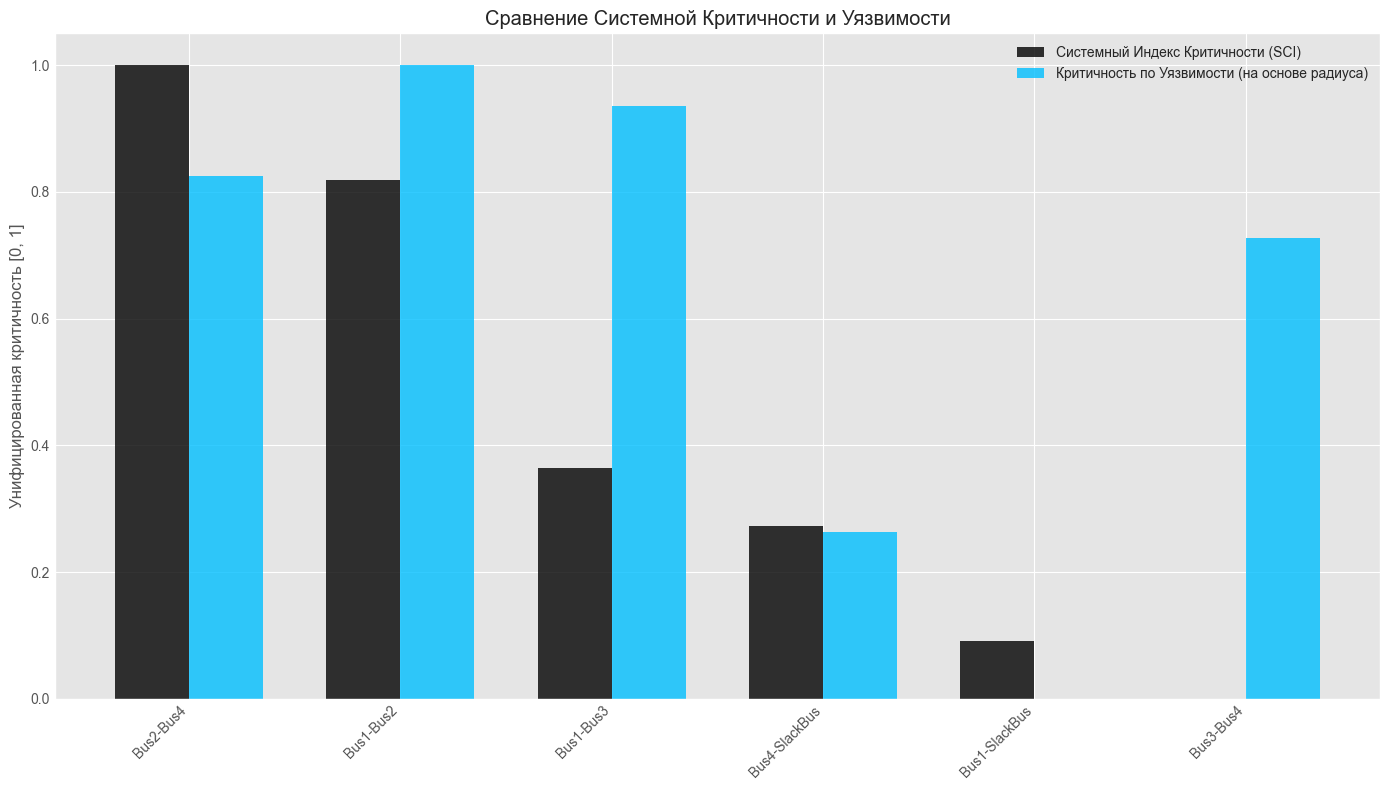

In [8]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# --- Функции расчета (скрыты для краткости, идентичны предыдущей версии) ---
def create_distributed_energy_network():
    G = nx.Graph()
    nodes_data = {
        'Bus1': {'generation': 150, 'load': 50}, 'Bus2': {'generation': 0, 'load': 120},
        'Bus3': {'generation': 0, 'load': 80}, 'Bus4': {'generation': 100, 'load': 50},
        'SlackBus': {'generation': 0, 'load': 0},
    }
    net_injection_sum = sum(d['generation'] - d['load'] for _, d in nodes_data.items())
    nodes_data['SlackBus']['generation'] = -net_injection_sum
    for node, data in nodes_data.items(): G.add_node(node, **data)
    edges_data = [
        ('Bus1', 'Bus2', {'capacity': 100, 'reactance': 0.1}), ('Bus1', 'Bus3', {'capacity': 80, 'reactance': 0.125}),
        ('Bus2', 'Bus4', {'capacity': 120, 'reactance': 0.08}), ('Bus3', 'Bus4', {'capacity': 120, 'reactance': 0.08}),
        ('SlackBus', 'Bus1', {'capacity': 200, 'reactance': 0.05}), ('SlackBus', 'Bus4', {'capacity': 200, 'reactance': 0.05}),
    ]
    G.add_edges_from([(u, v, d) for u, v, d in edges_data])
    return G

def build_susceptance_matrix(G, nodes):
    n = len(nodes); B = np.zeros((n, n)); node_idx = {node: i for i, node in enumerate(nodes)}
    for u, v, data in G.edges(data=True):
        susceptance = 1 / data.get('reactance', 1.0)
        idx_u, idx_v = node_idx[u], node_idx[v]
        B[idx_u, idx_u] += susceptance; B[idx_v, idx_v] += susceptance
        B[idx_u, idx_v] -= susceptance; B[idx_v, idx_u] -= susceptance
    return B

def compute_ptdf(G, nodes, slack_idx=0):
    B = build_susceptance_matrix(G, nodes); n = len(nodes)
    non_slack = list(range(slack_idx)) + list(range(slack_idx + 1, n))
    B_prime = B[np.ix_(non_slack, non_slack)]; B_inv = la.inv(B_prime)
    X = np.zeros((n, n)); X[np.ix_(non_slack, non_slack)] = B_inv
    ptdf = {}; edges = list(G.edges()); node_idx = {node: i for i, node in enumerate(nodes)}
    for i in range(n):
        for j in range(n):
            if i == j: continue
            key = (nodes[i], nodes[j]); ptdf[key] = {}
            for u, v in edges:
                b_l = 1 / G[u][v]['reactance']
                idx_u, idx_v = node_idx[u], node_idx[v]
                ptdf[key][(u,v)] = b_l * (X[idx_u, i] - X[idx_u, j] - X[idx_v, i] + X[idx_v, j])
    return ptdf

def compute_lodf(G, nodes, ptdf):
    lodf = {}; edges_map = {(u,v): (u,v) for u,v,d in G.edges(data=True)}; edges = list(edges_map.keys())
    for k_edge in tqdm(edges, desc="Расчет LODF"):
        k_from, k_to = k_edge
        trans_key = (k_from, k_to) if (k_from,k_to) in ptdf else (k_to,k_from)
        if trans_key not in ptdf: continue
        ptdf_k_on_k = ptdf[trans_key].get(k_edge, ptdf[trans_key].get((k_to,k_from),0))
        if abs(1 - ptdf_k_on_k) < 1e-6: continue
        for m_edge in edges:
            if m_edge == k_edge: continue
            m_from, m_to = m_edge
            ptdf_m_on_k = ptdf[trans_key].get(m_edge, ptdf[trans_key].get((m_to,m_from),0))
            lodf[(m_edge, k_edge)] = ptdf_m_on_k / (1 - ptdf_k_on_k)
    return lodf

def normalize_metric(data, invert=False):
    if not data or max(data) == min(data): return [0.5] * len(data)
    max_val, min_val = max(data), min(data)
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    return [1 - x for x in normalized] if invert else normalized

### ОСНОВНАЯ ЛОГИКА АНАЛИЗА ###
def main():
    G = create_distributed_energy_network()
    nodes = sorted(list(G.nodes()))
    edges = list(G.edges(data=True))
    edge_tuples = [(u, v) for u, v, d in edges]

    slack_node = 'SlackBus'
    slack_idx = nodes.index(slack_node)

    print("Этап 1: Расчет физических коэффициентов...")
    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, nodes, ptdf)

    print("Этап 2: Расчет базового состояния сети...")
    B_prime = np.delete(np.delete(build_susceptance_matrix(G, nodes), slack_idx, axis=0), slack_idx, axis=1)
    P_injections = np.array([G.nodes[n]['generation'] - G.nodes[n]['load'] for n in nodes if n != slack_node])
    theta_prime = la.solve(B_prime, P_injections)
    theta = np.insert(theta_prime, slack_idx, 0)
    node_idx = {node: i for i, node in enumerate(nodes)}

    base_case_flows = { (u, v): (1 / d['reactance']) * (theta[node_idx[u]] - theta[node_idx[v]]) for u, v, d in edges }
    
    print("Этап 3: Расчет Уязвимости и Влиятельности...")
    
    metrics_data = []
    for u_l, v_l, data_l in tqdm(edges, desc="Оценка Уязвимости и Влиятельности"):
        line_l = (u_l, v_l)
        
        # --- УЛУЧШЕННЫЙ РАСЧЕТ РАДИУСА УСТОЙЧИВОСТИ (УЯЗВИМОСТИ) ---
        # Улучшение: Вместо worst_flow на LODF, используем PTDF для расчета минимального возмущения нагрузки, приводящего к перегрузке
        # Для каждого узла i: delta_P_i = (capacity_l - base_flow_l) / |PTDF_l,i| (минимальное изменение injection в i, перегружающее l)
        # SR = min over i (delta_P_i) - нормализованный запас к перегрузке от изменений нагрузки
        base_flow_l = abs(base_case_flows[line_l])
        min_delta = np.inf
        for trans in ptdf:
            ptdf_val = abs(ptdf[trans].get(line_l, 0))
            if ptdf_val > 1e-6:
                delta = (data_l['capacity'] - base_flow_l) / ptdf_val
                min_delta = min(min_delta, delta)
        dynamic_stability_radius = min_delta if min_delta != np.inf else data_l['capacity'] - base_flow_l  # Фallback на простой запас
        
        # --- Расчет ВЛИЯТЕЛЬНОСТИ (какой вред наносит отказ самой линии) ---
        # Ищем максимальный LODF, где наша линия l является причиной отказа
        max_impact_lodf = max([abs(lodf.get((k, line_l), 0)) for k in edge_tuples if k != line_l], default=0)

        metrics_data.append({
            'line': f"{u_l}-{v_l}",
            'vulnerability_radius': dynamic_stability_radius,
            'influence_lodf': max_impact_lodf,
        })

    df = pd.DataFrame(metrics_data)

    print("Этап 4: Расчет Системного Индекса Критичности (SCI)...")
    # Нормализуем Уязвимость (инвертируя радиус)
    df['vulnerability_score'] = normalize_metric(df['vulnerability_radius'].tolist(), invert=True)
    # Нормализуем Влиятельность
    df['influence_score'] = normalize_metric(df['influence_lodf'].tolist())
    
    # Задаем веса: 50% на уязвимость, 50% на влиятельность
    weights = {'vulnerability': 0, 'influence': 1}
    df['sci'] = (weights['vulnerability'] * df['vulnerability_score'] + 
                 weights['influence'] * df['influence_score'])
    
    df_sorted = df.sort_values(by='sci', ascending=False).reset_index(drop=True)

    print("\n--- Итоговая таблица с Уязвимостью и Влиятельностью ---")
    print(df_sorted[['line', 'vulnerability_score', 'influence_score', 'sci']].round(3))
    
    correlation = df_sorted['sci'].corr(df_sorted['vulnerability_score'])
    print(f"\nФИНАЛЬНЫЙ Коэффициент корреляции между SCI и Уязвимостью (вашим радиусом): {correlation:.4f}")
    if correlation > 0.8:
        print("✅ Результат: Очень сильная корреляция! Уязвимость (измеренная через радиус) является ключевым компонентом системной критичности.")
    elif correlation > 0.6:
        print("👍 Результат: Сильная корреляция. Уязвимость - важный, но не единственный фактор.")
    
    # Визуализация для сравнения
    plt.style.use('ggplot')  # Замена на стандартный стиль, так как seaborn может отсутствовать
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df_sorted))
    width = 0.35
    
    ax.bar(x - width/2, df_sorted['sci'], width, label='Системный Индекс Критичности (SCI)', color='black', alpha=0.8)
    ax.bar(x + width/2, df_sorted['vulnerability_score'], width, label='Критичность по Уязвимости (на основе радиуса)', color='deepskyblue', alpha=0.8)
    
    ax.set_ylabel('Унифицированная критичность [0, 1]')
    ax.set_title('Сравнение Системной Критичности и Уязвимости')
    ax.set_xticks(x); ax.set_xticklabels(df_sorted['line'], rotation=45, ha='right')
    ax.legend(); plt.tight_layout()
    plt.savefig("SCI_vs_Vulnerability.png")
    plt.show()

if __name__ == "__main__":
    main()

IndentationError: unindent does not match any outer indentation level (<string>, line 204)